<a href="https://colab.research.google.com/github/Laetitia825/Phase-field-first-model/blob/main/first_try_230524.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install comfit -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.2/47.2 kB 1.6 MB/s eta 0:00:00


In [3]:
import comfit as cf
import numpy as np
import scipy as sp #Used for Fourier transforming
import matplotlib.pyplot as plt

class LandauSystem(cf.BaseSystem):

    def __init__(self,dim, k1, a,**kwargs):
        self.k1 = k1
        self.a = a
        super().__init__(dim, **kwargs)

In [71]:
ls = LandauSystem(2, 2, 0.5)


$$E=\int dr^2 \varepsilon(\phi,\nabla \phi)+g(\phi)[\mathscr{E_{strain}}-\mathscr{E_{c}}]$$
where
$$\varepsilon(\phi,\nabla \phi)= \frac{k}{2}|\nabla \phi|^2 + f(\phi)$$

We are looking for a functional ${f}$ so that its derivative vanishes in 0 and 1 to have two minimums in those points. Let's take $f(\phi) = \frac{\phi^2(\phi-1)^2}{4}$ to start with.

Then introducing a coupling constant $g$ so that  $g(0)=0$, $g(1)=1$, $g’(0)=0$ and $g’(1)=0$. The minimum in 0 should be lower than the one in 1. In fact when $\Delta \mathscr{E} >0$ the strain energy exceed the threshold energy and rupture happens, the broken state should be favored and $\phi$ equals zero.
Let's take : $g(\phi) = (4\phi^3 - 3\phi^4)$

Then the global energy equation can be written :     
$$
E=\int dr^2 \frac{|\nabla \phi|^2 }{2}+\frac{k_1}{4} \phi^2(1-\phi)^2+\alpha(4\phi^3-3\phi^4)$$
Where $k_1$ is a parameter to fix and $\alpha$ stands for the difference between the strain energy density and threshold energy density.



(<Figure size 640x480 with 1 Axes>, <Axes: xlabel='$x/a_0$'>)

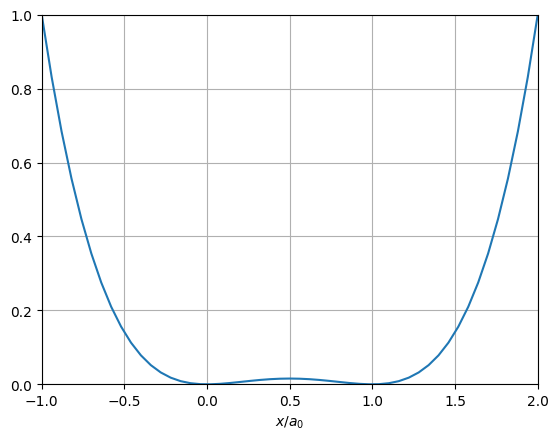

<Figure size 640x480 with 0 Axes>

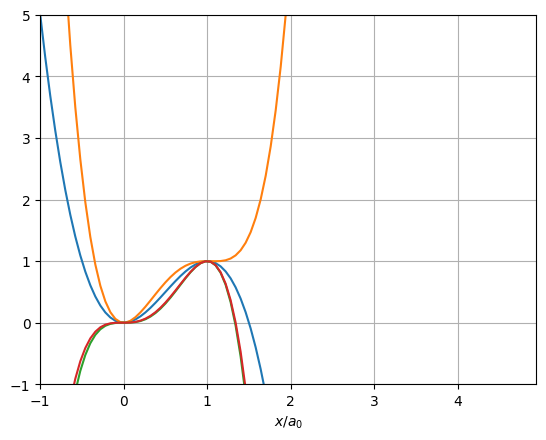

In [74]:
# Plot f and g functions
sys1 = cf.BaseSystem(1,xRes=100,xlim = (-1,5),ylim=(0,1))

f1 = 0.25*sys1.x**2*(sys1.x-1)**2

g = 3*sys1.x**2-2*sys1.x**3
g_2 = 4*sys1.x**3-3*sys1.x**4

f_g = 10*f1 +(1/1)*g
f_g_2 = 1*f1+(1/1)*g_2
# good shape only for alpha lower or equals to 0.2

sys1.plot_field(1*f1,xlim = (-1,2),ylim=(0,1), label = "f1")
plt.figure()
# sys1.plot_field(f2,xlim = (-1,2),ylim=(0,1), label = "f2")
plt.figure()
sys1.plot_field((1/1)*g, xlim = (-1,5),ylim=(-1,5), label = "g")
sys1.plot_field(f_g, label = "f_g")
# plt.figure()
sys1.plot_field((1/1)*g_2, xlim = (-1,5),ylim=(-1,5), label = "g")
sys1.plot_field(f_g_2, label = "f_g_2")
# plt.legend()

Thanks to the previous plot, we find different values for α that fits: it enables to check that for different values of \alpha, we still have two minimums in 0 and 1 and a lower minimum in 0 than in 1.

In [49]:
# Make linear operator
def calc_omega_f(self):
    return -self.calc_k2() - 0.5*self.k1

# Add method to class
LandauSystem.calc_omega_f = calc_omega_f

# Make the non-linear operator
def calc_nonlinear_evolution_function_f(self, field, t):
    # N = -self.k1*field**3+2*self.k1*field**2+6*self.a*field**2
    N = field**2*(3*self.k1/2-12*self.a)-field**3*(12*self.a-self.k1)
    return sp.fft.fftn(N)

# Add method to class
LandauSystem.calc_nonlinear_evolution_function_f = calc_nonlinear_evolution_function_f

In [50]:
def evolve(self, number_steps):
    omega_f = calc_omega_f(self)

    integrating_factors_f, solver = self.calc_integrating_factors_f_and_solver(omega_f, 'ETD2RK')

    for n in range(number_steps):
        self.psi, self.psi_f = solver(integrating_factors_f,
                                    self.calc_nonlinear_evolution_function_f,
                                    self.psi, self.psi_f)
        self.psi = np.real(self.psi)

# Add evolve method to class
LandauSystem.evolve = evolve

Initialisation with a $\phi$ field which is equal to one everywhere (intact material) except in the middle --> with \alpha >0 (=1 for example) the actual stable equilibrium is zero everywhere very quickly : after few steps the field approaches zero everywhere.
For example, with k1 = 10 and $α$ = 1, after 20 time steps the field has an order of magnitude of 1e-5 everywhere.

(<Figure size 640x480 with 2 Axes>, <Axes: xlabel='$x/a_0$', ylabel='$y/a_0$'>)

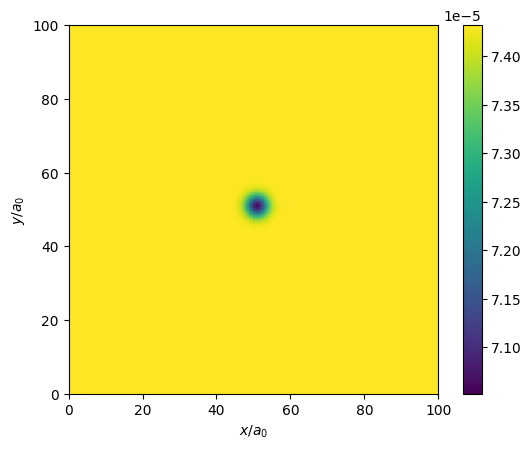

In [89]:
# Initiating a system with positive k1 and alpha values
ls = LandauSystem(2,10,1)

# Setting an initial condition with both positive and negative values
# ls.psi = np.random.rand(ls.xRes,ls.yRes)-0.5
ls.psi = np.ones((ls.xRes,ls.yRes))
ls.psi[51,51] = 0
ls.psi_f = sp.fft.fftn(ls.psi)

# Evolving the system
ls.evolve(20)
ls.plot_field(ls.psi)

(<Figure size 640x480 with 2 Axes>, <Axes: xlabel='$x/a_0$', ylabel='$y/a_0$'>)

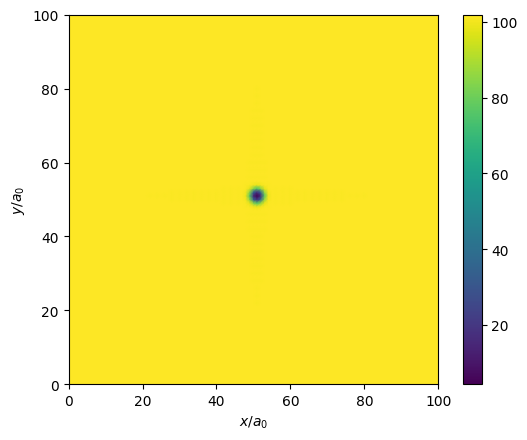

In [101]:
# Initiating a system with negative alpha value to see if it shrinks
ls = LandauSystem(2,1,0)

# Setting an initial condition with both positive and negative values
# ls.psi = np.random.rand(ls.xRes,ls.yRes)-0.5
ls.psi = np.ones((ls.xRes,ls.yRes))
ls.psi[51,51] = 0
ls.psi_f = sp.fft.fftn(ls.psi)

# Evolving the system
ls.evolve(4)
ls.plot_field(ls.psi)

When $\alpha$ is negative the phase field grow exponentially (after 2 time steps, for k1 = 10 and \alpha =-1, phase field order of magnitude of 1e19) --> I thought the phase field was bound between zero and 1 ?  

When α = 0 same, the phase field parameter grow with no limit.

Animation

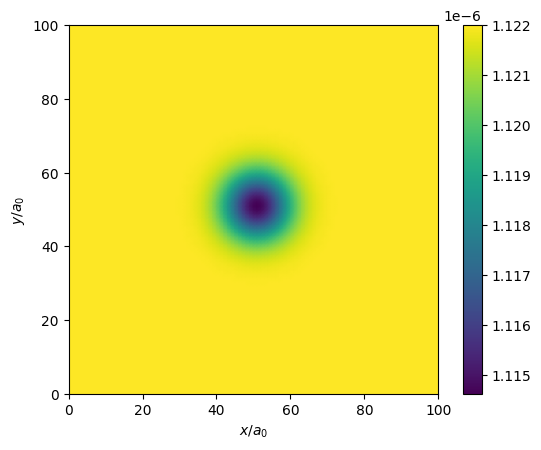

In [102]:
# Initiating a system with positive r value
ls = LandauSystem(2,1,1)

# Setting an initial condition with both positive and negative values
ls.psi = np.ones((ls.xRes,ls.yRes))
ls.psi[51,51] = 0
ls.psi_f = sp.fft.fftn(ls.psi)

# Make animation
for n in range(100):
    ls.evolve(2)
    plt.clf() #Clearing current figure before plotting new one
    ls.plot_field(ls.psi)
    cf.tool_save_plot(n)
cf.tool_make_animation_gif(n,name='evolution_1_1') #k=1 and a=1

  N = field**2*(3*self.k1/2-12*self.a)-field**3*(12*self.a-self.k1)



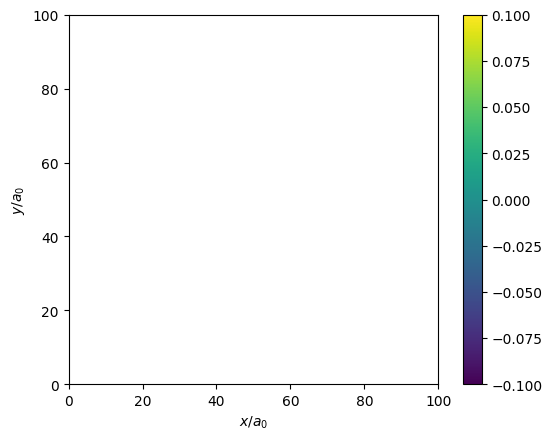

In [105]:
# Initiating a system with negative \alpha value
ls = LandauSystem(2,1,-1)

# Setting an initial condition with both positive and negative values
ls.psi = np.ones((ls.xRes,ls.yRes))
ls.psi[51,51] = 0
ls.psi_f = sp.fft.fftn(ls.psi)

# Make animation
for n in range(3): #--> values are so high that power overflow after few time steps
    ls.evolve(2)
    plt.clf() #Clearing current figure before plotting new one
    ls.plot_field(ls.psi)
    cf.tool_save_plot(n)
cf.tool_make_animation_gif(n,name='evolution_1_-1')